In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
import os
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dawudardiansyah","key":"70d8900102176266217a3ba4d53d0a99"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d shiv28/animal-5-mammal

100% 889M/892M [01:23<00:00, 21.3MB/s]
100% 892M/892M [01:23<00:00, 11.2MB/s]


In [5]:
!mkdir animalss
!unzip -qq animal-5-mammal.zip -d animalss
!ls animalss

Animal


In [6]:
!ls animalss/Animal/train/

cat  dog  ELEPHANT  HORSE  LION


In [7]:
animal1 = os.path.join('/content/animalss/Animal/train/')

print(os.listdir(animal1))

['dog', 'LION', 'cat', 'HORSE', 'ELEPHANT']


In [8]:
ignore_animals = ['dog']

for x in ignore_animals:
  path = os.path.join(animal1, x)
  shutil.rmtree(path)

In [9]:
list_animal1 = os.listdir(animal1)
print(list_animal1)

['LION', 'cat', 'HORSE', 'ELEPHANT']


In [10]:
total = 0

for x in list_animal1:
  dir = os.path.join(animal1, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)

LION: 2684
- (64, 64)
- (64, 64)
- (64, 64)
- (64, 64)
---------------
cat: 2737
- (512, 512)
- (512, 512)
- (512, 512)
- (512, 512)
---------------
HORSE: 2709
- (453, 340)
- (1024, 768)
- (500, 333)
- (64, 64)
---------------
ELEPHANT: 2740
- (64, 64)
- (64, 64)
- (64, 64)
- (310, 163)
---------------

Total : 10870


<function matplotlib.pyplot.show(*args, **kw)>

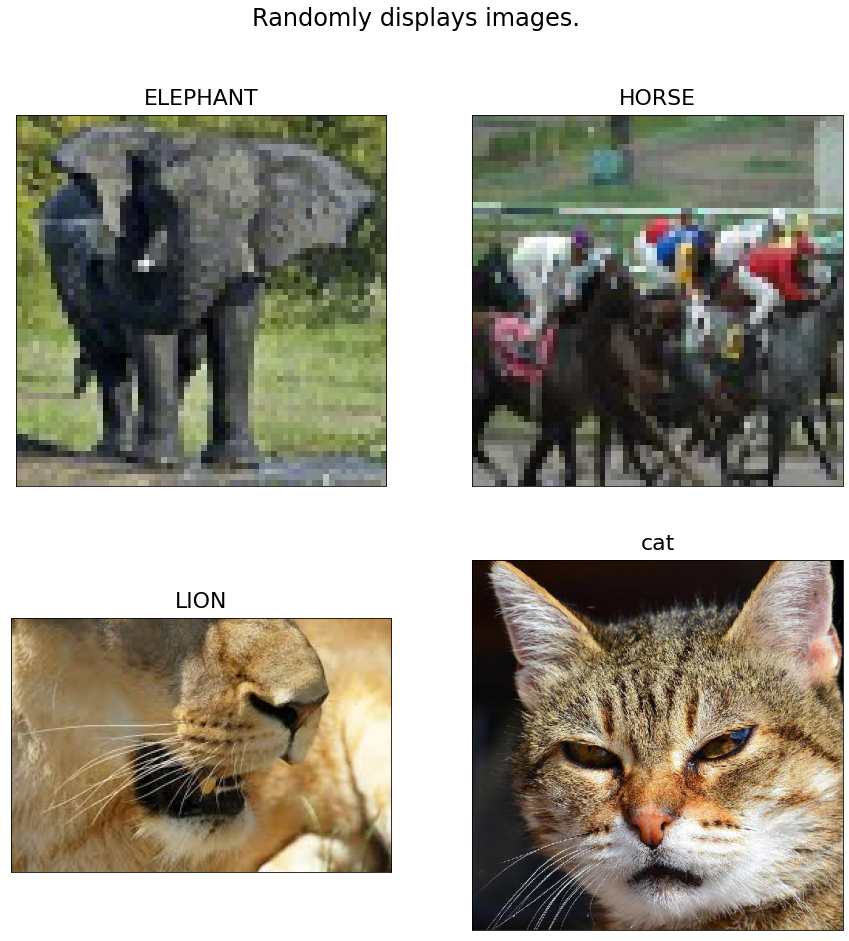

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Randomly displays images.", fontsize=24)
animal1_sorted = sorted(list_animal1)
animal1_id = 0
for i in range(2):
  for j in range(2):
    try:
      animal1_selected = animal1_sorted[animal1_id] 
      animal1_id += 1
    except:
      break
    if animal1_selected == '.TEMP':
        continue
    animal1_selected_images = os.listdir(os.path.join(animal1, animal1_selected))
    animal1_selected_random = np.random.choice(animal1_selected_images)
    img = plt.imread(os.path.join(animal1, animal1_selected, animal1_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(animal1_selected, pad=10, fontsize=22)
    
plt.setp(ax, xticks=[],yticks=[])
plt.show

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   
)
test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [22]:
batch_size = 256

data_train = train_datagen.flow_from_directory(
    animal1,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen.flow_from_directory(
    animal1, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 8697 images belonging to 4 classes.
Found 2172 images belonging to 4 classes.


In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [40]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.88):
      print("\nAccuracy above 90%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [41]:
history = model.fit(data_train, 
                    epochs = 50, 
                    steps_per_epoch = data_train.samples // batch_size,
                    validation_data = data_val, 
                    validation_steps = data_val.samples // batch_size,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/50
33/33 [==============================] - 85s 3s/step - loss: 0.2355 - accuracy: 0.9084 - val_loss: 0.2701 - val_accuracy: 0.8921
Epoch 2/50
33/33 [==============================] - 85s 3s/step - loss: 0.2190 - accuracy: 0.9164 - val_loss: 0.3010 - val_accuracy: 0.8887
Epoch 3/50
33/33 [==============================] - 84s 3s/step - loss: 0.2301 - accuracy: 0.9116 - val_loss: 0.2714 - val_accuracy: 0.8931
Epoch 4/50
33/33 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9215
Accuracy above 90%, finish training!
33/33 [==============================] - 84s 3s/step - loss: 0.2054 - accuracy: 0.9215 - val_loss: 0.2911 - val_accuracy: 0.8848


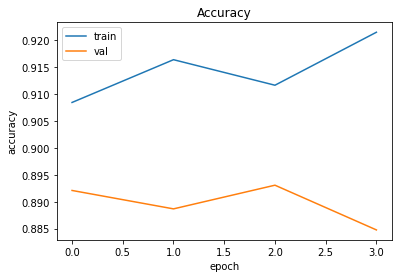

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

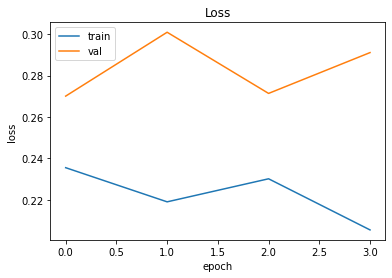

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

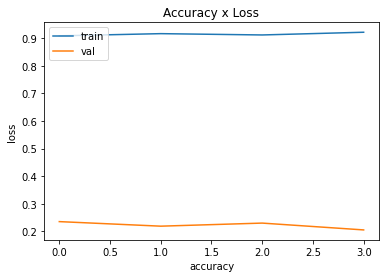

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Accuracy x Loss')
plt.ylabel('loss')
plt.xlabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)